### Query 
make $i_{mag} < 18$
~~~
    SELECT *
    FROM mean_param
    JOIN magnitudes ON mean_param.iau_name = magnitudes.iau_name
    WHERE magnitudes.i < 18;
~~~

In [382]:
import csv
import lightkurve as lk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np
import astropy.units as u
from astropy.modeling.models import Sine1D
from sklearn.linear_model import LinearRegression
import pandas as pd
from astropy.modeling import models, fitting
from lightkurve.correctors import PLDCorrector

In [383]:
palette = sns.color_palette(palette='Set1')
palette

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [384]:
# Define the sine wave function
def sine_wave(t, amplitude, frequency, phase, offset):
    return amplitude * np.sin((2 * np.pi * frequency * t) + phase) + offset

In [385]:
# Make query seperated by commas instead of spaces
with open('og_test_query.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')

    with open('comma_test_query.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        
        # Iterate through each row
        for row in reader:
            # Replace spaces for commas for each element
            modified_row = [column.replace(' ', ',') for column in row]
            
            writer.writerow(modified_row)

In [386]:
df = pd.read_csv('comma_test_query.csv')

all_df = df[['iau_name', 'i', 'porb', 'porbe']]
porb_df = all_df[all_df['porb'] != 0].reset_index()
no_porb_df = all_df[all_df['porb'] == 0].reset_index()

print(porb_df)
print(no_porb_df)

    index                 iau_name        i       porb         porbe
0      18  SDSSJ005245.11-005337.2  17.9716   2.735000  2.000000e-03
1      23  SDSSJ011009.09+132616.1  17.0235   7.984495  3.000000e-06
2      30  SDSSJ013851.54-001621.6  15.8900   1.746529  1.000000e-09
3      33  SDSSJ015225.38-005808.5  16.9841   2.151947  9.900000e-06
4      44  SDSSJ023804.39-000545.7  17.6982   5.080100  4.800000e-03
..    ...                      ...      ...        ...           ...
58    899  SDSSJ162354.45+630640.4  17.3778  53.562400  3.400000e-03
59    906  SDSSJ184412.58+412029.4  15.6925   5.416600  1.000000e-03
60    914  SDSSJ224307.59+312239.1  17.2834   2.870300  5.900000e-03
61    919  SDSSJ231105.66+220208.6  17.4523  13.922400  1.700000e-03
62    924  SDSSJ013532.97+144555.9  17.1633   1.698000  1.200000e+00

[63 rows x 5 columns]
     index                 iau_name         i  porb  porbe
0        0  SDSSJ000152.09+000644.7  17.50190   0.0    0.0
1        1  SDSSJ001339.10+0019

### Orbital Period Found

In [387]:
porb_df.iloc[0]

index                            18
iau_name    SDSSJ005245.11-005337.2
i                           17.9716
porb                          2.735
porbe                         0.002
Name: 0, dtype: object

In [421]:
star_result = lk.search_lightcurve(porb_df.iloc[0]['iau_name'], mission='TESS')
star_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 70,2023,SPOC,120,333640393,0.0


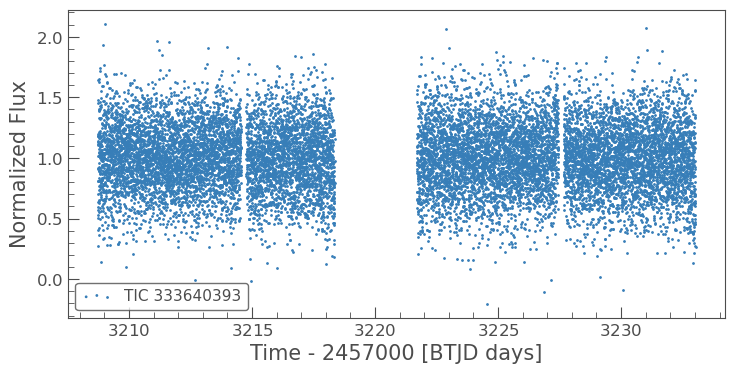

In [422]:
star_lightcurve = star_result[0].download().remove_nans().remove_outliers().normalize()
star_lightcurve.scatter(color=palette[1])
plt.show()

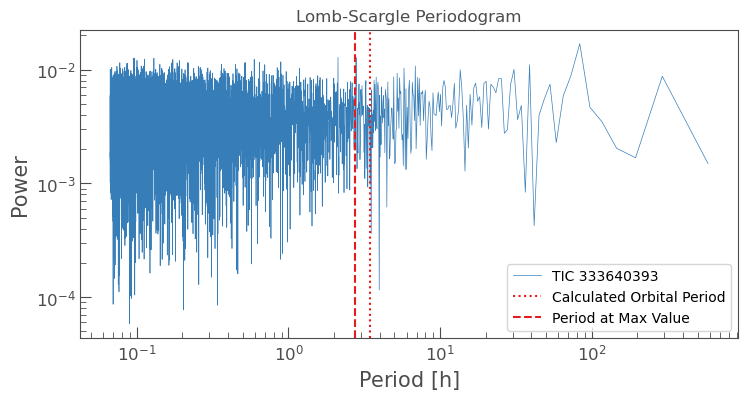

In [424]:
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)
star_periodogram.plot(color=palette[1], view='period', scale='log', unit=u.hr)
plt.axvline(x=star_periodogram.period_at_max_power.value, color=palette[0], label = 'Calculated Orbital Period', ls = 'dotted')
plt.axvline(x=2.735, color=palette[0], ls = 'dashed', label = 'Period at Max Value')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

In [391]:
best_period = 2.735
star_periodogram.period, star_periodogram.power, star_periodogram.period_at_max_power

(<Quantity [2.42944826e+01, 1.21472413e+01, 8.09816086e+00, ...,
            2.77873528e-03, 2.77841750e-03, 2.77809978e-03] d>,
 <Quantity [0.001496  , 0.00872794, 0.00167811, ..., 0.00392877, 0.00382947,
            0.00185728]>,
 <Quantity 3.47064037 d>)

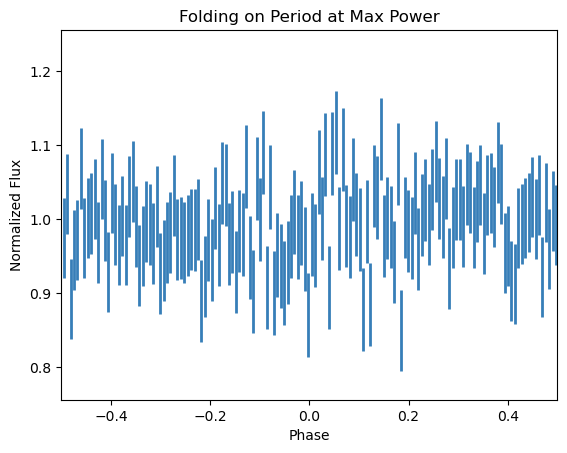

In [392]:
# Defined folded and binned lightcurve
phase_lightcurve = star_lightcurve.fold(period=star_periodogram.period_at_max_power)
binned_lightcurve = phase_lightcurve.bin(10*u.min)

# Define phase, and lower and upper bounds of flux
phase = binned_lightcurve.phase.value
flux_lower_err = binned_lightcurve.flux - binned_lightcurve.flux_err
flux_upper_err = binned_lightcurve.flux + binned_lightcurve.flux_err

# Plot
plt.vlines(phase, flux_lower_err, flux_upper_err, color=palette[1], lw=2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Folding on Period at Max Power')
plt.xlim(-0.5, 0.5)
plt.show()

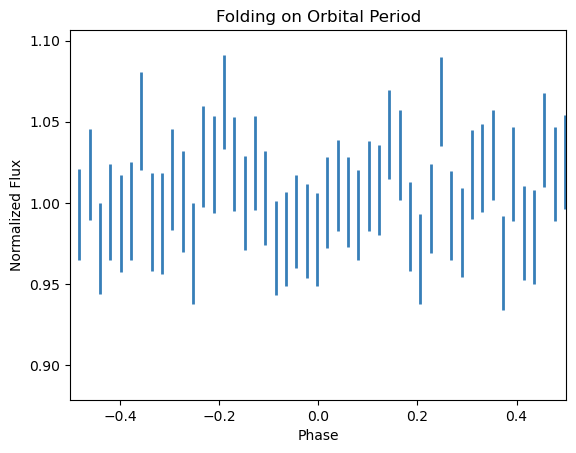

In [393]:
# Defined folded and binned lightcurve
phase_lightcurve = star_lightcurve.fold(period=best_period)
binned_lightcurve = phase_lightcurve.bin(30*u.min) # check what bin SHOULD be

# Define phase, flux, and lower and upper flux bounds 
phase = binned_lightcurve.phase.value
flux = binned_lightcurve.flux.value
flux_lower_err = binned_lightcurve.flux - binned_lightcurve.flux_err
flux_upper_err = binned_lightcurve.flux + binned_lightcurve.flux_err


# Plot
plt.vlines(phase, flux_lower_err, flux_upper_err, color=palette[1], lw=2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Folding on Orbital Period')
plt.xlim(-0.5, 0.5)
plt.show()

$y(t)=Asin(2πft+ϕ)$ \
Where: \
$y(t)$ is the displacement or amplitude of the wave at time $t$ \
$A$ is the amplitude \
$f$ is the frequency (the number of cycles per second, measured in Hertz) \
$\phi$ is the phase (the initial position of the wave, measured in radians) \
$t$ is the time variable

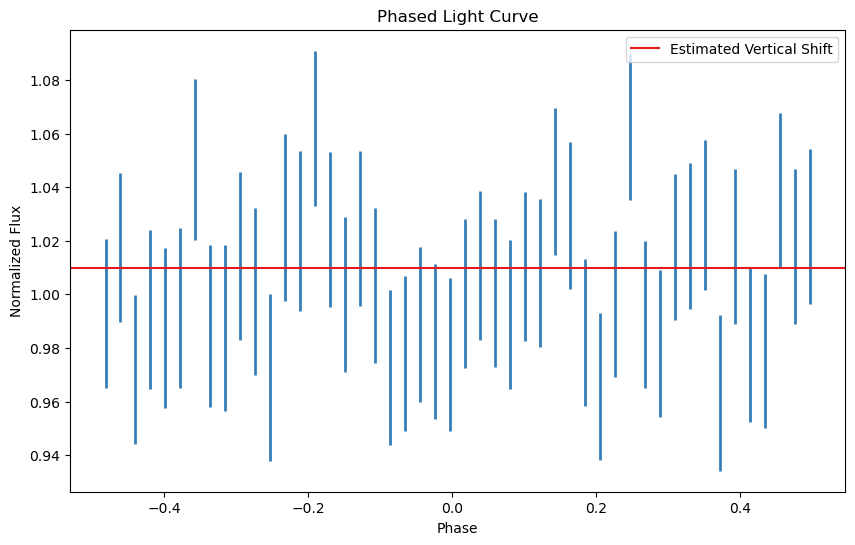

In [394]:
# Define the phase range
phase_range = np.logical_and(phase >= -0.5, phase <= 0.5)
phase_in_range = phase[phase_range]
flux_in_range = flux[phase_range]
flux_lower_err_in_range = flux_lower_err[phase_range]
flux_upper_err_in_range = flux_upper_err[phase_range]

plt.figure(figsize=(10, 6))
plt.vlines(phase_in_range, flux_lower_err_in_range, flux_upper_err_in_range, color=palette[1], lw=2)
plt.axhline(y = 1.01, color = palette[0], label = 'Estimated Vertical Shift')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Phased Light Curve')
plt.legend()
plt.show()

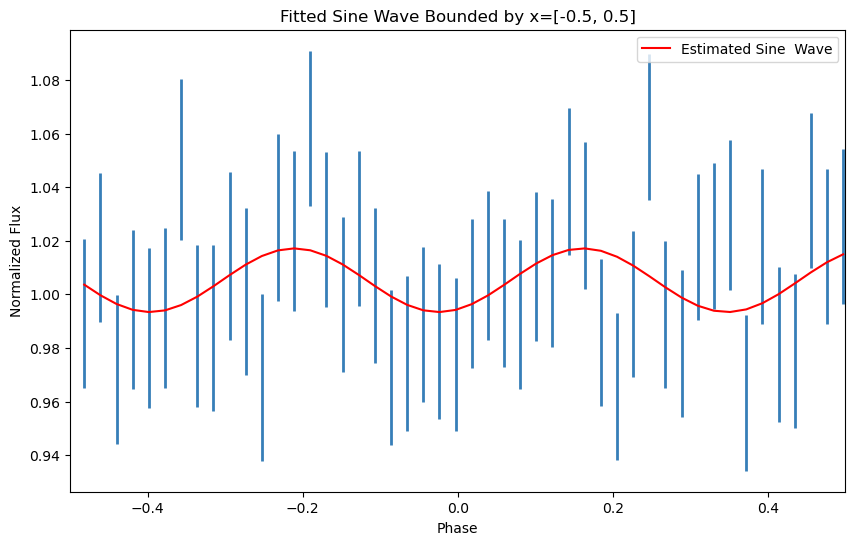

In [395]:
# Fit sin wave using bounded phase and flux
initial_guess = (1, 2, 0, 1) # amplitude, frequency, phase, offset

params, params_covariance = curve_fit(sine_wave, phase_in_range, flux_in_range, p0=initial_guess)
fitted_sin = sine_wave(phase_in_range, *params)

plt.figure(figsize=(10, 6))
plt.vlines(phase_in_range, flux_lower_err_in_range, flux_upper_err_in_range, color=palette[1], lw=2)
plt.xlim(-0.5, 0.5)
plt.plot(phase_in_range, fitted_sin, color= 'red', label = 'Estimated Sine  Wave')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Fitted Sine Wave Bounded by x=[-0.5, 0.5]')
plt.legend()
plt.show()

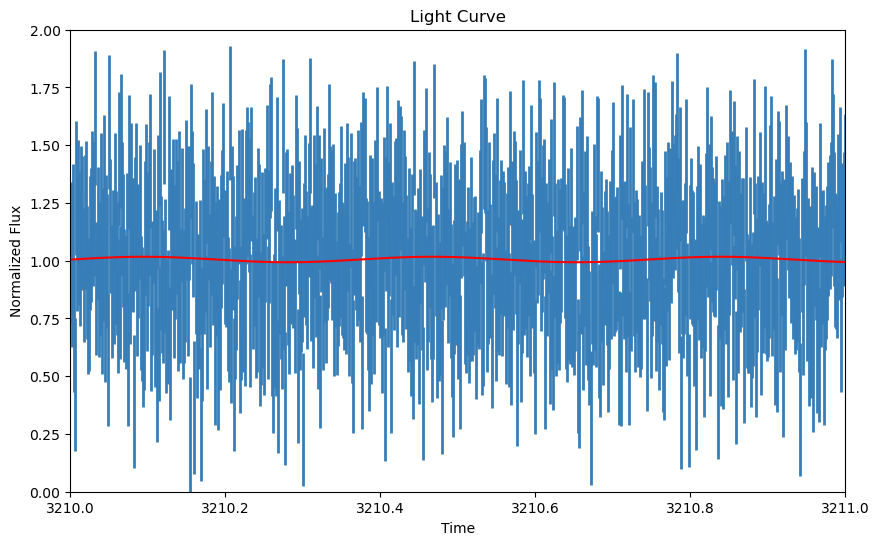

In [396]:
# Define lightcurve x(time) and y(flux) parameters
time = star_lightcurve.time.value
flux = star_lightcurve.flux.value

# Define error bars
flux_lower_err = star_lightcurve.flux - star_lightcurve.flux_err
flux_upper_err = star_lightcurve.flux + star_lightcurve.flux_err

fitted_sin = sine_wave(time, *params)

plt.figure(figsize=(10, 6))
plt.vlines(time, flux_lower_err, flux_upper_err, color=palette[1], lw=2)
plt.plot(time, fitted_sin, color= 'red')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Light Curve')
plt.xlim(3210, 3211)
plt.ylim(0, 2)
plt.show()
plt.show()

In [397]:
# Extract frequency from fitting parameters
amplitude, frequency, phase, offset = params

# Calculate period
period = 1 / frequency

print("Period:", period)

# NOTE: different from found period?

Period: 0.3724252330723259


In [398]:
# Gaussian fit?


In [399]:
porb_df.iloc[1]

index                            23
iau_name    SDSSJ011009.09+132616.1
i                           17.0235
porb                       7.984495
porbe                      0.000003
Name: 1, dtype: object

In [400]:
star_result = lk.search_lightcurve(porb_df.iloc[1]['iau_name'], mission='TESS')
star_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 42,2021,SPOC,20,408253347,0.0
1,TESS Sector 43,2021,SPOC,20,408253347,0.0
2,TESS Sector 42,2021,SPOC,120,408253347,0.0
3,TESS Sector 43,2021,SPOC,120,408253347,0.0
4,TESS Sector 70,2023,SPOC,20,408253347,0.0
5,TESS Sector 70,2023,SPOC,120,408253347,0.0
6,TESS Sector 42,2021,TESS-SPOC,600,408253347,0.0
7,TESS Sector 43,2021,TESS-SPOC,600,408253347,0.0


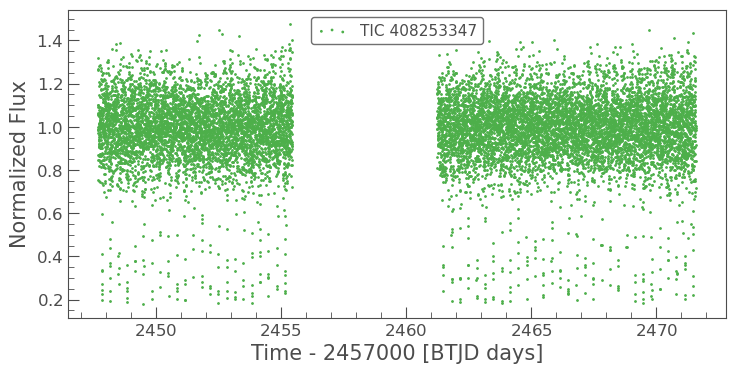

In [401]:
star_lightcurve = star_result[2].download().remove_nans().remove_outliers().normalize()
# maybe bin this ^^^ and plot with v lines here!!!!!
star_lightcurve.scatter(color=palette[2])
plt.show()

/Users/bella/anaconda3/envs/pceb_ob_ENV/lib/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


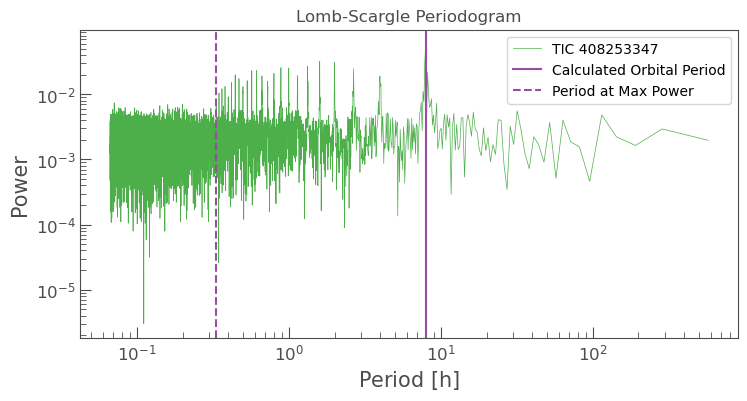

In [402]:
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)
star_periodogram.plot(color=palette[2], view='period', scale='log', unit=u.hr)
plt.axvline(x=7.984495, color=palette[3], label = 'Calculated Orbital Period')
plt.axvline(x=star_periodogram.period_at_max_power.value, color=palette[3], linestyle='--', label = 'Period at Max Power')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

In [403]:
best_period = 7.984495
star_periodogram.period, star_periodogram.power, star_periodogram.period_at_max_power

(<Quantity [2.38792791e+01, 1.19396396e+01, 7.95975971e+00, ...,
            2.77859892e-03, 2.77827564e-03, 2.77795243e-03] d>,
 <Quantity [0.00197234, 0.00294249, 0.00163948, ..., 0.00256466, 0.00175263,
                   nan]>,
 <Quantity 0.33165665 d>)

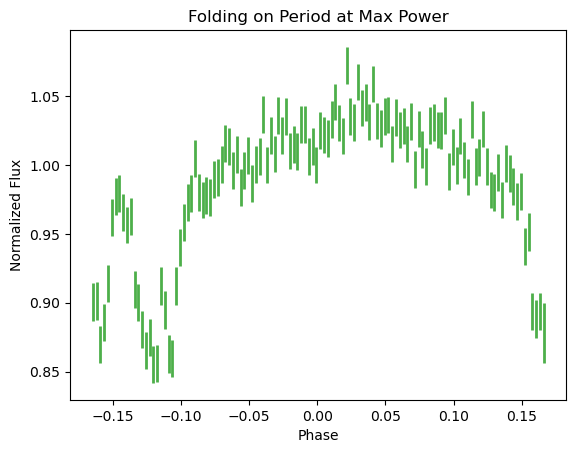

In [404]:
# Defined folded and binned lightcurve
phase_lightcurve = star_lightcurve.fold(period=star_periodogram.period_at_max_power)
binned_lightcurve = phase_lightcurve.bin(4*u.min)

# Define phase, and lower and upper bounds of flux
phase = binned_lightcurve.phase.value
flux_lower_err = binned_lightcurve.flux - binned_lightcurve.flux_err
flux_upper_err = binned_lightcurve.flux + binned_lightcurve.flux_err

# Plot
plt.vlines(phase, flux_lower_err, flux_upper_err, color=palette[2], lw=2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Folding on Period at Max Power')
# plt.xlim(-0.5, 0.5)
plt.show()

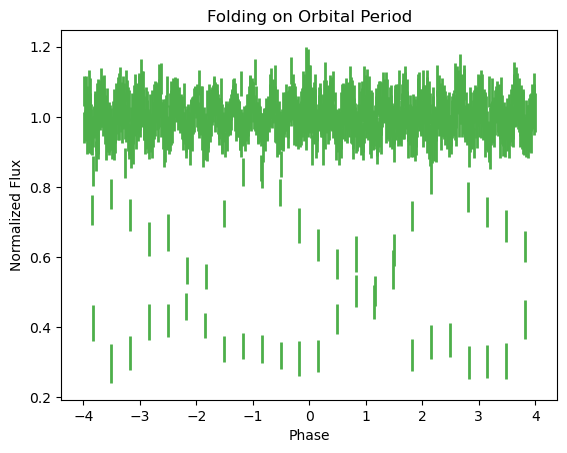

In [405]:
# Defined folded and binned lightcurve
phase_lightcurve = star_lightcurve.fold(period=best_period)
binned_lightcurve = phase_lightcurve.bin(10*u.min) # check what bin SHOULD be

# Define phase, flux, and lower and upper flux bounds 
phase = binned_lightcurve.phase.value
flux = binned_lightcurve.flux.value
flux_lower_err = binned_lightcurve.flux - binned_lightcurve.flux_err
flux_upper_err = binned_lightcurve.flux + binned_lightcurve.flux_err


# Plot
plt.vlines(phase, flux_lower_err, flux_upper_err, color=palette[2], lw=2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Folding on Orbital Period')
# plt.xlim(-0.5, 0.5)
plt.show()

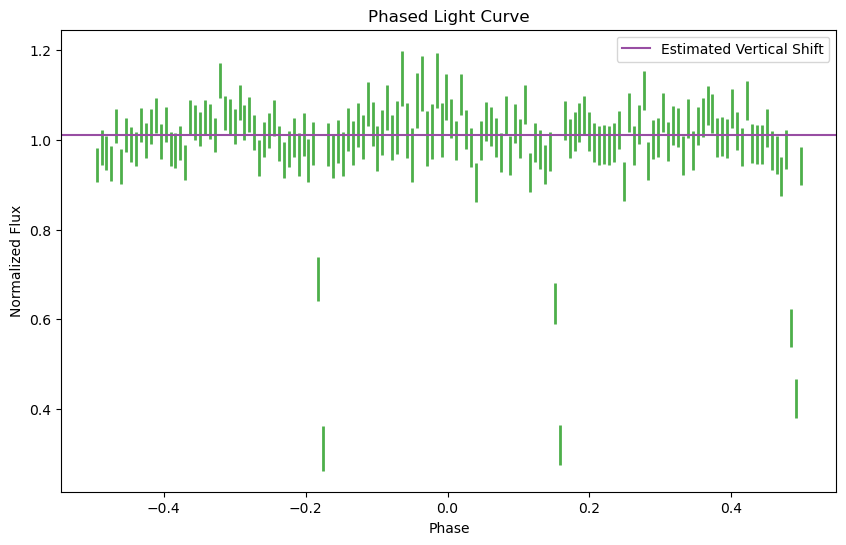

In [406]:
# Define the phase range
phase_range = np.logical_and(phase >= -0.5, phase <= 0.5)
phase_in_range = phase[phase_range]
flux_in_range = flux[phase_range]
flux_lower_err_in_range = flux_lower_err[phase_range]
flux_upper_err_in_range = flux_upper_err[phase_range]

plt.figure(figsize=(10, 6))
plt.vlines(phase_in_range, flux_lower_err_in_range, flux_upper_err_in_range, color=palette[2], lw=2)
plt.axhline(y = 1.01, color = palette[3], label = 'Estimated Vertical Shift')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Phased Light Curve')
plt.legend()
plt.show()

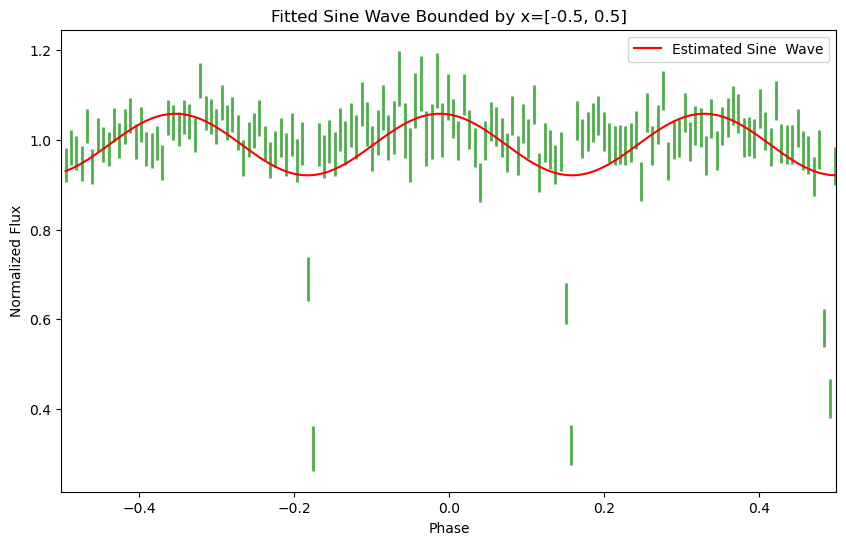

In [407]:
# Fit sin wave using bounded phase and flux
initial_guess = (1, 2, 0, 1) # amplitude, frequency, phase, offset

params, params_covariance = curve_fit(sine_wave, phase_in_range, flux_in_range, p0=initial_guess)
fitted_sin = sine_wave(phase_in_range, *params)

plt.figure(figsize=(10, 6))
plt.vlines(phase_in_range, flux_lower_err_in_range, flux_upper_err_in_range, color=palette[2], lw=2)
plt.xlim(-0.5, 0.5)
plt.plot(phase_in_range, fitted_sin, color= 'red', label = 'Estimated Sine  Wave')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Fitted Sine Wave Bounded by x=[-0.5, 0.5]')
plt.legend()
plt.show()

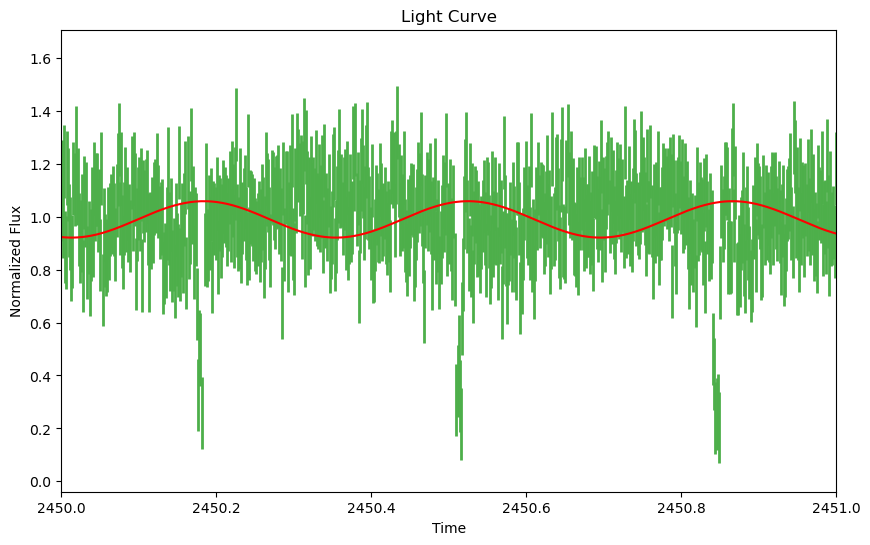

In [408]:
# Define lightcurve x(time) and y(flux) parameters
time = star_lightcurve.time.value
flux = star_lightcurve.flux.value

# Define error bars
flux_lower_err = star_lightcurve.flux - star_lightcurve.flux_err
flux_upper_err = star_lightcurve.flux + star_lightcurve.flux_err

fitted_sin = sine_wave(time, *params)

plt.figure(figsize=(10, 6))
plt.vlines(time, flux_lower_err, flux_upper_err, color=palette[2], lw=2)
plt.plot(time, fitted_sin, color= 'red')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Light Curve')
plt.xlim(2450, 2451)
plt.show()
plt.show()

In [409]:
# Extract frequency from fitting parameters
amplitude, frequency, phase, offset = params

# Calculate period
period = 1 / frequency

print("Period:", period)

# NOTE: different from found period?

Period: 0.34111034900322074


In [410]:
porb_df.iloc[2]

index                            30
iau_name    SDSSJ013851.54-001621.6
i                             15.89
porb                       1.746529
porbe                           0.0
Name: 2, dtype: object

In [411]:
star_result = lk.search_lightcurve(porb_df.iloc[2]['iau_name'], mission='TESS')
star_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 70,2023,SPOC,120,241444875,0.0
1,TESS Sector 03,2018,TESS-SPOC,1800,241444875,0.0
2,TESS Sector 30,2020,TESS-SPOC,600,241444875,0.0
3,TESS Sector 42,2021,TESS-SPOC,600,241444875,0.0
4,TESS Sector 43,2021,TESS-SPOC,600,241444875,0.0
5,TESS Sector 30,2020,QLP,600,241444875,0.0
6,TESS Sector 42,2021,QLP,600,241444875,0.0
7,TESS Sector 43,2021,QLP,600,241444875,0.0
8,TESS Sector 70,2023,QLP,200,241444875,0.0


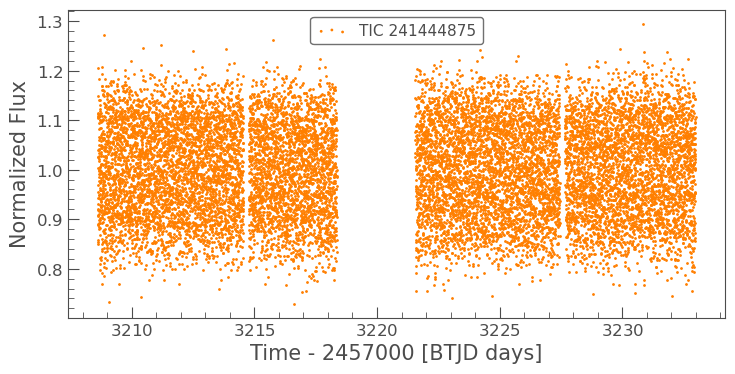

In [412]:
star_lightcurve = star_result[0].download().remove_nans().remove_outliers().normalize()
star_lightcurve.scatter(color=palette[4])
plt.show()

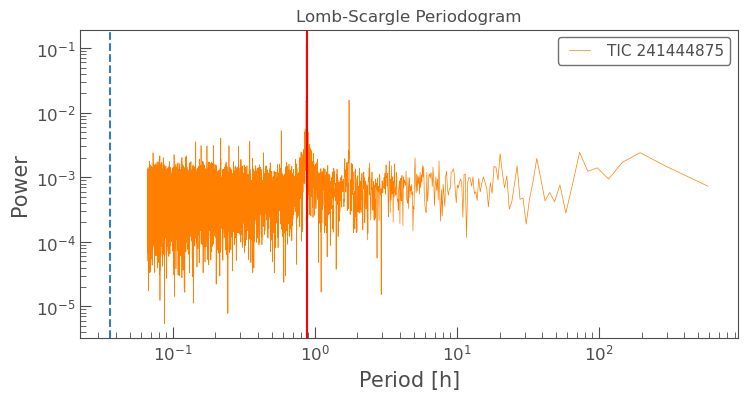

In [413]:
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)
star_periodogram.plot(color=palette[4], view='period', scale='log', unit=u.hr)
plt.axvline(x=star_periodogram.period_at_max_power.value, color=palette[1], linestyle='--')
plt.axvline(x=0.88, color = 'red')
plt.title('Lomb-Scargle Periodogram')
plt.show()

In [414]:
star_periodogram.period, star_periodogram.power, star_periodogram.period_at_max_power

(<Quantity [2.43768828e+01, 1.21884414e+01, 8.12562760e+00, ...,
            2.77862565e-03, 2.77830896e-03, 2.77799234e-03] d>,
 <Quantity [0.00072732, 0.00150138, 0.0024014 , ..., 0.00034705, 0.00019485,
            0.00034695]>,
 <Quantity 0.03638341 d>)

# FINISH ME!!!!!!!!!!!!!!!!!!!!!!!!

In [415]:
porb_df.iloc[9]

index                           106
iau_name    SDSSJ082145.27+455923.4
i                           17.6232
porb                      12.218165
porbe                      0.000002
Name: 9, dtype: object

In [416]:
star_result = lk.search_lightcurve(porb_df.iloc[9]['iau_name'], mission='TESS')
star_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 20,2019,SPOC,120,802015620,0.0
1,TESS Sector 47,2021,SPOC,120,802015620,0.0
2,TESS Sector 60,2022,SPOC,120,802015620,0.0
3,TESS Sector 20,2019,TESS-SPOC,1800,802015620,0.0
4,TESS Sector 47,2021,TESS-SPOC,600,802015620,0.0
5,TESS Sector 60,2022,TESS-SPOC,200,802015620,0.0


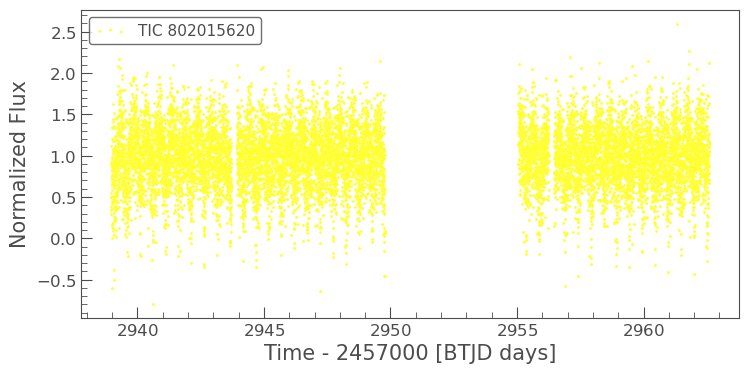

In [417]:
star_lightcurve = star_result[2].download().remove_nans().remove_outliers().normalize()
star_lightcurve.scatter(color=palette[5])
plt.show()

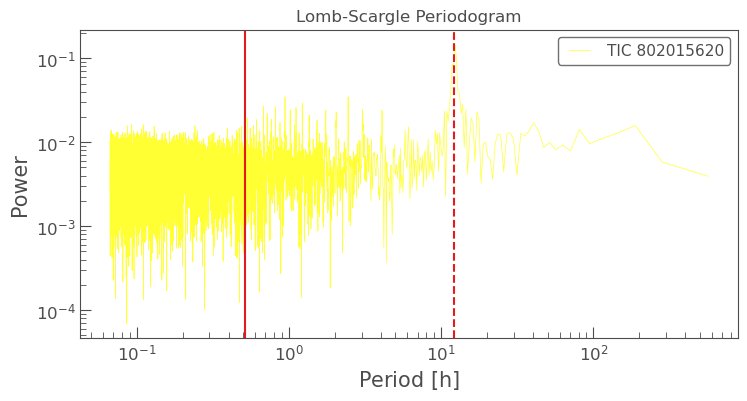

In [418]:
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)
star_periodogram.plot(color=palette[5], view='period', scale='log', unit=u.hr)
plt.axvline(x=star_periodogram.period_at_max_power.value, color=palette[0])
plt.axvline(x=12.218165, color=palette[0], linestyle='--')
plt.title('Lomb-Scargle Periodogram')
plt.show()

In [419]:
best_period = star_periodogram.period_at_max_power
star_periodogram.period, star_periodogram.power, star_periodogram.period_at_max_power

(<Quantity [2.36198546e+01, 1.18099273e+01, 7.87328486e+00, ...,
            2.77880642e-03, 2.77847954e-03, 2.77815274e-03] d>,
 <Quantity [0.00392801, 0.00580599, 0.01576458, ..., 0.00223119, 0.0048123 ,
            0.00589377]>,
 <Quantity 0.5134751 d>)